In [2]:
!pip install skorch

     |████████████████████████████████| 155 kB 2.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [172]:
!pip install mmdnn

     |████████████████████████████████| 318 kB 2.3 MB/s            


In [3]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1982.2 MB 4.1 kB/s eta 0:00:011  |█                               | 61.6 MB 8.6 MB/s eta 0:03:44     |█████▌                          | 342.8 MB 10.5 MB/s eta 0:02:36     |██████████████████████▌         | 1393.1 MB 9.6 MB/s eta 0:01:02     |█████████████████████████████▉  | 1847.7 MB 8.6 MB/s eta 0:00:16
     |████████████████████████████████| 17.6 MB 144 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 2.3 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0.dev20210415+cu101
    Uninstalling torch-1.9.0.dev20210415+cu101:
      Successfully uninstalled torch-1.9.0.dev20210415+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0.dev20210510+cu101
    Uninstalling torchvision-0.10.0.dev20210510+cu101:
      Successfully uninstalled torchvision-0.10.0.dev20210510+cu101
You should consi

In [286]:
!pip3 install --upgrade tensorflow-gpu

     |████████████████████████████████| 458.3 MB 16 kB/s              
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.5.0
    Uninstalling tensorflow-gpu-2.5.0:
      Successfully uninstalled tensorflow-gpu-2.5.0


In [275]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 458.3 MB 16 kB/s              
     |████████████████████████████████| 1.3 MB 31.4 MB/s            
     |████████████████████████████████| 5.6 MB 38.5 MB/s            
     |████████████████████████████████| 462 kB 38.8 MB/s            
     |████████████████████████████████| 4.4 MB 40.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30693 sha256=f1854b277822580858432aebb70fc38e7977469ffdb500e60342f16871f35570
  Stored in directory: /root/.cache/pip/wheels/22/4c/94/0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalle

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from tqdm import tqdm

In [5]:
!nvidia-smi

Sun Jun 12 04:18:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [142]:
segmentation_classifier = keras.models.load_model('../models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')
segmentation_classifier.summary()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_3[0][0]       

In [273]:
# log dice loss is custom, so can't load. but since I only want inference, will ignore the loss func. (might have to retrain?)

optic_disk = load_model('../models/optic_disk/aug_segmenter_adam3_best_weights.h5', compile=False) # failed :(
optic_disk.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 480, 480) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 480, 480) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (BatchNormalization)    (None, 32, 480, 480) 128         conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_3 (Dropout)               (None, 32, 480, 480) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

In [293]:
qual_assurance = load_model('../models/quality_assurance/IQA_model.h5')

In [294]:
qual_assurance.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [2]:
# code in one place, running in another directory
# code is to be run in below directory

os.chdir("/users/riya/race/classifier_experiments/CNN_train")

In [3]:
!ls

dataset  outputs


## Prepare Dataset

### Prepare Optic Disk Dataset

Code in Markdown form (don't run again!)

```python
# will generate a csv of all the centers of the optic disks per id, this will speed up classification 
    
csv_path = "/users/riya/race/csv/image_race_data.csv" 
data_path = "/users/riya/race/dataset/fundus/" # takes in fundus images
save_path = "/users/riya/race/optic_disk/DeepROP/dataset/" 

# 1. Copy DeepROP folder into 
# 2. get all the fundus images into DeepROP folder in the dataset location, just copy from data_path 
# 3. run the DeepROP folder using docker. Use docker mount. Get the output
# 4. Save the .csv. 
# 5. Extract image id from full path column and create new image id column. Save the .csv and now you can use that.
    
# 1 Done
# 2

# getting all the files in the source directory

files = os.listdir(data_path)
for i in files:
    img_id = os.path.splitext(i)[0]
    img = Image.open(data_path + img_id + ".png")
    img.save(save_path + img_id + ".bmp") 

```

### Prepare Race Dataset

We'll try a 70/10/20 split (train/val/test). We don't have access to info outside of black/white and posterior, so we'll just do a simple split.

In [ ]:
race_data = pd.read_csv("/users/riya/race/csv/image_race_data.csv")

In [ ]:
pd.value_counts(race_data['race'])

In [151]:
def prepare_dataset():
    
    csv_path = "/users/riya/race/csv/image_race_data.csv"
    data_path = "/users/riya/race/dataset/segmentations/"
    save_path = "/users/riya/race/classifier_experiments/CNN_train/dataset/"
    QA_csv_path = "../optic_disk/DeepROP/quality_assurance/QA.csv"
    
    race_data = pd.read_csv(csv_path)
    
    # only choose race_data ids that have (x,y) coordinates
    
    QA_csv = pd.read_csv(QAcsv_path)
    QA_csv.columns.values[0] = "img_id"
    QA_csv.columns = QA_csv.columns.to_series().apply(lambda x: x.strip())
    QA_csv[['img_id', 'Full path', 'x', 'y', 'is_posterior']]
    
    is_posterior_True = QA_csv[QA_csv['is_posterior'] == True]
    working_ids = np.array(is_posterior_True['img_id'])
    
    race_optic_data = pd.DataFrame(columns = ['subject_id', 'race', 'variable', 'value', 
                                          'image_id', 'fundus_location', 'segmentation_location'])

    for i in range(len(race_data)):
        row = race_data.loc[(i)]
        if row['image_id'] in working_ids:
            race_optic_data = race_optic_data.append(row)
    
    race_data = race_optic_data # reassign original
    
    race_data['stratify'] = race_data['race'] + '_' + race_data['variable'] 
    # new column so I can account for both variable and race in my stratification
    
    ratio_train = 0.7
    ratio_val = 0.1
    ratio_test = 0.2
    
    # split into 80% train and val, 20% test
    
    X_intermediate, X_test, y_intermediate, y_test = train_test_split(race_data, race_data['race'], test_size=ratio_test, 
                                                        stratify = race_data['stratify'], random_state=86)
    
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining
    
    # split into 70% train and 10% val
    
    X_train, X_val, y_train, y_val = train_test_split(X_intermediate, X_intermediate['race'], test_size=ratio_val_adjusted, 
                                                        stratify = X_intermediate['stratify'], random_state=86)

    
    def populate_folders(data_df, data_type):
    
        for i in tqdm(range(len(data_df))):
            data_df.reset_index(drop=True, inplace=True)
            img_id = data_df['image_id'][i]
            race = data_df['race'][i]

            img = np.array(Image.open(data_path + str(img_id) + '.bmp'))
            img = Image.fromarray(img)

            img.save(save_path + str(data_type) + '/' + str(race) + '/' + str(img_id) + '.bmp')
    
    populate_folders(X_train, 'train')
    populate_folders(X_val, 'val')
    populate_folders(X_test, 'test')


In [152]:
prepare_dataset() # proper train test split getting completed

100%|██████████| 675/675 [00:04<00:00, 156.43it/s]


### Model Definitions

In [4]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model

    def forward(self, x):
        return self.model(x)

In [135]:
# fail :( class OpticDiskSegmenter(nn.Module):


## Preprocessing

Options for different tests:
1. Skeleton = True,
    Shadow = True then
    Region has two options 
    Radius has two options
2. Original Training: shadow = False & Skeleton = False
3. skeletonization training: shadow = False & skeleton = True & ring = False
4. no skeletonization training: Skeleton = false & Shadow = true
5. training with a ring: shadow is true, skeleton is true/False, ring is True

In [141]:
'hello.bmp' + '.bmp'

'hello.bmp.bmp'

### General Functions

In [129]:
checksum_arr = []
id_arr = []

optic_csv_path = "../../optic_disk/DeepROP/quality_assurance/QA.csv"
data_compare_path = "/users/riya/race/dataset/segmentations/"

QA_csv = pd.read_csv(optic_csv_path)
    
QA_csv.columns.values[0] = "img_id"
QA_csv.columns = QA_csv.columns.to_series().apply(lambda x: x.strip())
QA_csv[['img_id', 'Full path', 'x', 'y', 'is_posterior']]
    
QA_csv = QA_csv[QA_csv['is_posterior'] == True]
    
for i in tqdm(QA_csv['img_id']):
    img_compare = np.array(Image.open(data_compare_path + str(i) + '.bmp'))
    all_sum = np.concatenate(img_compare).sum()
    col_sum = img_compare[:,100:240].sum()
    checksum_arr.append(all_sum + col_sum)
    id_arr.append(i)
    

100%|██████████| 3371/3371 [00:10<00:00, 333.39it/s]


In [92]:
checksum_dict = {id_arr[i]: checksum_arr[i] for i in range(len(id_arr))}


In [121]:
for name, age in checksum_dict.items():
    if age == 2364285:
        print(name)

84359
88758


In [122]:
my_test_img = np.array(Image.open("/users/riya/race/dataset/segmentations/40786.bmp"))
my_test_img2 = np.array(Image.open("/users/riya/race/dataset/segmentations/40795.bmp"))


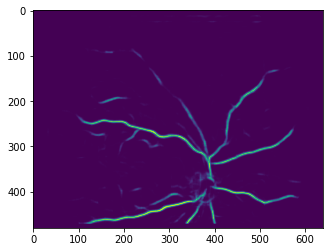

In [123]:
plt.imshow(my_test_img)

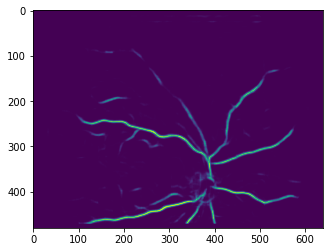

In [124]:
plt.imshow(my_test_img2)

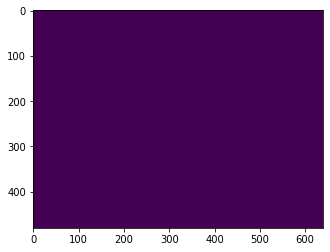

In [125]:
plt.imshow(my_test_img2 - my_test_img)

In [98]:
checksum_dict

{100282: 839970,
 100283: 1802376,
 100285: 1225826,
 100286: 1593160,
 100287: 1438312,
 100344: 3301808,
 100345: 3987640,
 100346: 3858834,
 100347: 3260060,
 100350: 3517546,
 100351: 6162629,
 100353: 4571742,
 100354: 3219405,
 100355: 5184748,
 100357: 5385095,
 100466: 1725526,
 100469: 2866755,
 100470: 2801973,
 100473: 2964473,
 100475: 1739459,
 100476: 4294712,
 100477: 2139583,
 100478: 3192567,
 100480: 2140137,
 100481: 4203205,
 101127: 4192400,
 101129: 2703929,
 101130: 3723053,
 101131: 3696737,
 101444: 1821843,
 101694: 646940,
 101696: 563918,
 101697: 942806,
 101698: 1778221,
 101699: 2046921,
 101700: 682581,
 101702: 460200,
 101703: 3313439,
 101704: 1107691,
 101706: 473101,
 101709: 1206944,
 101710: 542018,
 101712: 1006414,
 101714: 240692,
 101715: 2801127,
 101716: 1511921,
 101717: 2349696,
 101718: 712550,
 101721: 1782728,
 101722: 313462,
 101723: 842660,
 101724: 437413,
 101726: 357136,
 101727: 2756724,
 101728: 1235531,
 101730: 1069118,
 10173

In [130]:
len(checksum_arr)

3371

In [ ]:
def checksum():

### Functions to be Lamda Applied

In [19]:
def determine_image_center(img, img_size, optic_csv_path): # using optic disk
    
    img_og = np.array(img) # our original image
    img_og = img_og[:,:,0]
    
    id_og = '' # original id of image, for comparison

    data_compare_path = "/users/riya/race/dataset/segmentations/"
    
    # csv_path = "../../optic_disk/DeepROP/quality_assurance/QA.csv" # could load in.
    QA_csv = pd.read_csv(optic_csv_path)
    
    QA_csv.columns.values[0] = "img_id"
    QA_csv.columns = QA_csv.columns.to_series().apply(lambda x: x.strip())
    QA_csv[['img_id', 'Full path', 'x', 'y', 'is_posterior']]
    
    QA_csv = QA_csv[QA_csv['is_posterior'] == True]
    
    for i in tqdm(QA_csv['img_id']):
        img_compare = Image.open(data_compare_path + str(i) + '.bmp') # compare image
        img_compare = np.array(img_compare)
        # img_compare = np.repeat(img_compare[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))
        # img_compare.resize()
        # channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

        subtract_img = img_compare - img_og

        is_all_zero = np.all((subtract_img == 0))


        if is_all_zero == True:
            print("TRUE")
            id_og = i # img id, NOT str format
            break
    
    # all images are of size 480 x 480
    
    img_row = QA_csv[QA_csv['img_id'] == id_og] # check if string
    
    y_og = img_row['y'].reset_index(drop=True)[0]
    x_og = img_row['x'].reset_index(drop=True)[0]
    
    x_pos = (80 + y_og) * img_size[1]/640 # x size is 640, cropped that way
    y_pos = (480 - x_og)* img_size[0]/480 # y size is 480 (also, height is first in img size tuple, so the 0)
    
    disk_center = (int(x_pos), int(y_pos)) # for (224, 224) image that will be created soon
    
    return disk_center

In [5]:
# Already done this, before I saved my images
# Yay, we did the same thing, repeating the image thrice to create the three layers. I can just do that part.

# Oh, I see. Rather than saving ALL the images (as I wrongly did), it's so much easier to just make them in the train code!

# depending on the inputs, I can run this code 8 times to train this model. It'll be easy to train at that point!

def shadow_regions(img, skeleton, disk_center, shadow, radius, 
                   shadow_ring, ring_radiuses, region, 
                   image_size = (224, 224)):
    
    img = np.array(img)
    img = cv2.resize(img, image_size)
    
    # defining channel which will be duplicated late (in case it's not already with Image Folder??)
    channel = img[:,:,0]
    
    # disk_center is WEEEIRD, how to get working??

    if skeleton is True:
        # can binarize all 3 channels, but will go 1 at a time
        channel[channel > 0] = 255       
        modified_img = skeletonize(channel, method='lee')
        
    elif skeleton is not True:
        modified_img = channel
    
    if shadow is True: # want to do either shadow or shadow_ring, not both
        
        if shadow_ring is True:
            # ring_radiuses is [inner_radius, outer_radius]
        
            # developing mask that darkens ring portion
            center_mask = np.full(image_size, 255, dtype=np.uint8) 
            # radius i changes, center, color, fill is the same
            cv2.circle(center_mask, disk_center, ring_radiuses[1], (0, 0, 0), -1)
            # adding circle to darken inside region
            cv2.circle(center_mask, disk_center, ring_radiuses[0], (255,255, 255), -1)
        
        elif shadow_ring is not True:
            # developing mask that darkens center portion
            center_mask = np.full(image_size, 255, dtype=np.uint8)
            # radius i changes, center, color, fill is the same
            cv2.circle(center_mask, disk_center, radius, (0, 0, 0), -1) # disk_center received from optic disk segmenter, tuple

        # developing mask that darkens background region (same in case of ring)
        back_mask = cv2.bitwise_not(center_mask)

        if (region == 'dark_center'): # could be for ring or not for ring
            modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=center_mask)

        if (region == 'dark_background'):
            modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=back_mask)
            
    elif shadow is not True: # if condition here for clarity     
        modified_img2 = modified_img
        
    img[:,:,0] = modified_img2
    img[:,:,1] = modified_img2
    img[:,:,2] = modified_img2
    
    img = Image.fromarray(img)

    return img

### Testing The Transforms

#### Shadow Center & Optic Disk Manual

In [190]:
my_test_img = np.array(Image.open("/users/riya/race/dataset/segmentations/9145.bmp"))
# my_test_img = cv2.resize(my_test_img, (224, 224)) at that point, images are NOT resized yet
test_channels = np.repeat(my_test_img[:, :, np.newaxis], 3, axis=2).reshape((480,640,3))

In [191]:
disk_center = determine_image_center(test_channels, (224, 224), "../../optic_disk/DeepROP/quality_assurance/QA.csv")

# kinda takes forever lol

 78%|███████▊  | 2626/3371 [00:07<00:02, 366.73it/s]

TRUE


In [192]:
disk_center

(175, 120)

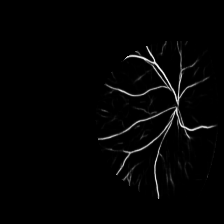

In [198]:
shadow_regions(test_channels, False, disk_center, True, 80, 
                   False, [45,60], 'dark_background', 
                   image_size = (224, 224))

#### Lambda Transforms Style :D

In [232]:
test_transforms = transforms.Compose([transforms.Lambda
                                      (lambda img: shadow_regions(img, True, 
                                                                  determine_image_center(img, (224, 224), "../../optic_disk/DeepROP/quality_assurance/QA.csv"), 
                                                                  True, 45, True, [45, 60], 'dark_center'))])

In [233]:
data_dir = os.path.join('dataset')
test_folder = os.path.join(data_dir, 'test')

test_dataset = datasets.ImageFolder(test_folder, test_transforms)


In [234]:
test_folder

'dataset/test'

In [235]:
len(test_dataset)

675

In [264]:
labels = np.array(test_dataset.samples)[:,1]


In [38]:

optic_disk_csv = "../../optic_disk/DeepROP/quality_assurance/QA.csv"

train_transforms = transforms.Compose([transforms.Lambda
                                      (lambda img: shadow_regions(img, False, determine_image_center(img, (224, 224), optic_disk_csv), 
                                                                  True, 10, False, [0, 0], 'dark_center'))])

In [48]:
train_folder = os.path.join('dataset', 'train') # only training on segmentations      

train_dataset = datasets.ImageFolder(train_folder, train_transforms)


In [49]:
train_dataset.class_to_idx

{'black': 0, 'white': 1}

In [50]:
img = train_dataset.__getitem__(1)[0]

  1%|          | 27/3371 [00:00<00:09, 352.95it/s]

TRUE


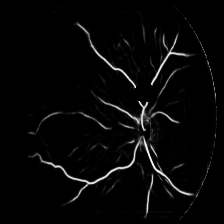

In [51]:
img

In [52]:
my_test_img = np.array(Image.open("dataset/train/black/101130.bmp"))

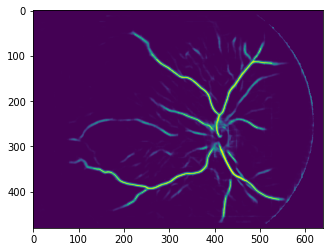

In [53]:
plt.imshow(my_test_img)

In [24]:
labels = np.array(train_dataset.samples)[:,1].astype(int)


In [14]:
train_dataset.samples[:,1] = np.array(train_dataset.samples)[:,1]

TypeError: list indices must be integers or slices, not tuple

In [26]:
labels - 1

array([0, 0, 0, ..., 1, 1, 1])

In [25]:
labels[0]

1

In [13]:
len(labels)

2359

In [20]:
len(labels[labels == '1'])

922

In [ ]:
    
# what even does the below code do?    
labels = labels.astype(int)
black_weight = 1 / len(labels[labels == 0])

In [236]:
img = test_dataset.__getitem__(40)[0]

 20%|██        | 681/3371 [00:01<00:05, 511.28it/s]

TRUE


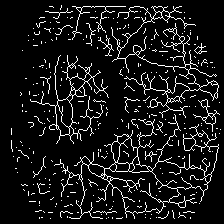

In [237]:
img

In [239]:
img.size

(224, 224)

### Train Code

In [15]:
def train(data_dir, radius, ring_radiuses, region, skeleton=False, shadow = False, shadow_ring = False,
          num_classes=2, batch_size=64, num_epochs=10, lr=0.001, image_size = (224, 224)): 
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # 
    if device == 'cuda:1': # using all available gpus
        torch.cuda.empty_cache()
    if skeleton is True: # Experiment #2: skeleton true, shadow true
        shadow = True
        f_params = f'./outputs/checkpoints/model_shadow_regions_{region}_{radius}_skeletonized_epoch{num_epochs}.pt'
        f_history = f'./outputs/histories/model_shadow_regions_{region}_{radius}_skeletonized_epoch{num_epochs}.json'
        csv_name = f'./outputs/probabilities/shadow_regions_{region}_{radius}_skeletonized_epoch{num_epochs}.csv'
    elif shadow is True: # Experiment #3: skeleton false, shadow true
        f_params = f'./outputs/checkpoints/model_shadow_regions_{region}_{radius}_epoch{num_epochs}.pt'
        f_history = f'./outputs/histories/model_shadow_regions_{region}_{radius}_epoch{num_epochs}.json'
        csv_name = f'./outputs/probabilities/shadow_regions_{region}_{radius}_epoch{num_epochs}.csv'
    else: # Original training: skeleton false, shadow false
        f_params = f'./outputs/checkpoints/model_original_epoch{num_epochs}.pt'
        f_history = f'./outputs/histories/model_original_epoch{num_epochs}.json'
        csv_name = f'./outputs/probabilities/original_epoch{num_epochs}.csv'
        
    # fix these transforms w/ new optic disk
    
    optic_disk_csv = "../../optic_disk/DeepROP/quality_assurance/QA.csv"
    
    train_transforms = transforms.Compose([transforms.Lambda
                                      (lambda img: shadow_regions(img, skeleton, determine_image_center(img, image_size, optic_disk_csv), 
                                                                  shadow, radius, shadow_ring, ring_radiuses, region)), # image size pre-defined
                                           # transforms.Resize(image_size),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(25),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.5, 0.5, 0.5],
                                                                [0.5, 0.5, 0.5])]) # why this normalizing?
    
    test_transforms = transforms.Compose([transforms.Lambda
                                      (lambda img: shadow_regions(img, skeleton, determine_image_center(img, image_size, optic_disk_csv), 
                                                                  shadow, radius, shadow_ring, ring_radiuses, region)),
                                          # transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],
                                                               [0.5, 0.5, 0.5])])

    train_folder = os.path.join(data_dir, 'train') # only training on segmentations      
    val_folder = os.path.join(data_dir, 'val')
    test_folder = os.path.join(data_dir, 'test')
    
    print ("Train/Test/Val datasets to be created. Thank you for your patience.")

    # I guess this automatically creates 3 channels
    train_dataset = datasets.ImageFolder(train_folder, train_transforms)
    val_dataset = datasets.ImageFolder(val_folder, test_transforms)
    test_dataset = datasets.ImageFolder(test_folder, test_transforms)
    
    print ("Train/Test/Val datasets created.")

    labels = np.array(train_dataset.samples)[:,1]
    
    # what even does the below code do?    
    labels = labels.astype(int) # idk what changed 6/17/22?? going from 0 and 1, to 1 and 2 labels. Ok, fixed. ipynb checkpoints!!
    black_weight = 1 / len(labels[labels == 0]) 
    white_weight = 1 / len(labels[labels == 1])
    sample_weights = np.array([black_weight, white_weight])
    weights = sample_weights[labels]
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(train_dataset), replacement=True)

    print()
    print(f'Data Directory: {data_dir}')
    print(f'Skeletonize: {skeleton}')
    print(f'Shadow: {shadow}')
    print(f'Number of Classes: {num_classes}')
    print(f'Number of black eyes: {len(labels[labels == 0])}')
    print(f'Number of white eyes: {len(labels[labels == 1])}')
    print(f'Batch Size: {batch_size}')
    print(f'Number of Epochs: {num_epochs}')
    print(f'Initial Learning Rate: {lr}')
    print(f'Device: {device}')
    print()

    # maybe increase size of validation set??
    
    checkpoint = Checkpoint(monitor='valid_loss_best',
                            f_params=f_params,
                            f_history=f_history,
                            f_optimizer=None,
                            f_criterion=None)

    # accuracy on train/validation?
    
    train_acc = EpochScoring(scoring='accuracy',
                             on_train=True,
                             name='train_acc',
                             lower_is_better=False)

    early_stopping = EarlyStopping()

    callbacks = [checkpoint, train_acc, early_stopping]

    net = NeuralNetClassifier(PretrainedModel,
                              criterion=nn.CrossEntropyLoss,
                              lr=lr,
                              batch_size=batch_size,
                              max_epochs=num_epochs,
                              module__output_features=num_classes,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.9,
                              iterator_train__num_workers=16,
                              iterator_train__sampler=sampler,
                              iterator_valid__shuffle=False,
                              iterator_valid__num_workers=16,
                              train_split=predefined_split(val_dataset),
                              callbacks=callbacks,
                              device=device)

    print ("Model Fitting")
    net.fit(train_dataset, y=None)

    img_locs = [loc for loc, _ in test_dataset.samples]
    test_probs = net.predict_proba(test_dataset)
    test_probs = [prob[0] for prob in test_probs] # probability of being black
    data = {'img_loc' : img_locs, 'probability' : test_probs}
    pd.DataFrame(data=data).to_csv(csv_name, index=False)

In [16]:
if __name__ == '__main__':
    if not os.path.isdir(os.path.join('outputs', 'probabilities')):
        os.makedirs(os.path.join('outputs', 'probabilities'))
    if not os.path.isdir(os.path.join('outputs', 'checkpoints')):
        os.makedirs(os.path.join('outputs', 'checkpoints'))
    if not os.path.isdir(os.path.join('outputs', 'histories')):
        os.makedirs(os.path.join('outputs', 'histories'))

    data_dir = os.path.join('dataset')

    train(data_dir, 0, [0], 'none')

Train/Test/Val datasets to be created. Thank you for your patience.
Train/Test/Val datasets created.

Data Directory: dataset
Skeletonize: False
Shadow: False
Number of Classes: 2
Number of black eyes: 922
Number of white eyes: 1437
Batch Size: 64
Number of Epochs: 10
Initial Learning Rate: 0.001
Device: cuda:1

Model Fitting
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUETRUE

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TR

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUETRUE

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUETRUE

TRUE
TRUE
TRUE


TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUETRUE

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


KeyboardInterrupt: 

In [17]:
!nvidia-smi

Fri Jun 17 07:25:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   42C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [11]:
if __name__ == '__main__':
    if not os.path.isdir(os.path.join('outputs', 'probabilities')):
        os.makedirs(os.path.join('outputs', 'probabilities'))
    if not os.path.isdir(os.path.join('outputs', 'checkpoints')):
        os.makedirs(os.path.join('outputs', 'checkpoints'))
    if not os.path.isdir(os.path.join('outputs', 'histories')):
        os.makedirs(os.path.join('outputs', 'histories'))

    data_dir = os.path.join('dataset')

    train(data_dir, 0, 0)
    
    # training 4 skeleton + shadow models for experiment #2
    train(data_dir, 45, 'dark_center',skeleton=True, shadow = True)
    train(data_dir, 45, 'dark_background',skeleton=True, shadow = True)
    train(data_dir, 90, 'dark_center',skeleton=True, shadow = True)
    train(data_dir, 90, 'dark_background',skeleton=True, shadow = True)


Data Directory: dataset
Skeletonize: False
Shadow: False
Number of Classes: 2
Number of black eyes: 1197
Number of white eyes: 1984
Batch Size: 64
Number of Epochs: 10
Initial Learning Rate: 0.001
Device: cuda:1



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.6863        0.5921       0.7495        0.4688     +  22.8890
      2       0.8155        0.4124       0.7407        0.5353        21.8471
      3       0.8368        0.3691       0.8154        0.4002     +  21.8220
      4       0.8554        0.3248       0.8242        0.4030        21.9117
      5       0.8752        0.2868       0.8440        0.3105     +  21.9440
      6       0.8790        0.2809       0.8440        0.3081     +  21.9060
      7       0.8950        0.2489       0.8396        0.3381        22.0916
      8       0.8887        0.2568       0.8681        0.2731     +  22.0817
      9       0.9010        0.2324       0.8659        0.2625     +  22.1679
     10       0.9135        0.2148       0.8879        0.2351     +  22.0017

Data Directory: dataset
Skeletonize: True
Shadow: True
Number of Classes: 2

In [12]:
if __name__ == '__main__':
    if not os.path.isdir(os.path.join('outputs', 'probabilities')):
        os.makedirs(os.path.join('outputs', 'probabilities'))
    if not os.path.isdir(os.path.join('outputs', 'checkpoints')):
        os.makedirs(os.path.join('outputs', 'checkpoints'))
    if not os.path.isdir(os.path.join('outputs', 'histories')):
        os.makedirs(os.path.join('outputs', 'histories'))

    data_dir = os.path.join('dataset')
    # training 4 no skeleton + shadow models for experiment #2
    train(data_dir, 45, 'dark_center',skeleton=False, shadow = True)
    train(data_dir, 45, 'dark_background',skeleton=False, shadow = True)
    train(data_dir, 90, 'dark_center',skeleton=False, shadow = True)
    train(data_dir, 90, 'dark_background',skeleton=False, shadow = True)


Data Directory: dataset
Skeletonize: False
Shadow: True
Number of Classes: 2
Number of black eyes: 1197
Number of white eyes: 1984
Batch Size: 64
Number of Epochs: 10
Initial Learning Rate: 0.001
Device: cuda:1

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.6841        0.5804       0.7231        0.5297     +  22.4284
      2       0.7843        0.4495       0.6374        0.7344        22.4209
      3       0.8255        0.3987       0.7934        0.4313     +  22.4387
      4       0.8412        0.3616       0.7956        0.4073     +  22.3537
      5       0.8434        0.3474       0.6484        0.8646        22.3640
      6       0.8428        0.3353       0.8176        0.3857     +  22.4248
      7       0.8535        0.3129       0.8242        0.3743     +  22.4087
      8       0.8548        0.3198       0.8330        0.3701     +  22.4373
      9       0.8

After, try training more than 10 epochs!

In [1]:
!nvidia-smi

Sun Jun 12 16:45:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   43C    P8    58W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [4]:
test_predictions = pd.read_csv("./outputs/probabilities/original.csv")

In [5]:
test_predictions

,img_loc,probability
0,dataset/test/black/101131.bmp,0.457056
1,dataset/test/black/101696.bmp,0.972327
2,dataset/test/black/101704.bmp,0.982587
3,dataset/test/black/101708.bmp,0.945986
4,dataset/test/black/101710.bmp,0.976698
...,...,...
905,dataset/test/white/99948.bmp,0.000573
906,dataset/test/white/99960.bmp,0.000091
907,dataset/test/white/99969.bmp,0.000517
908,dataset/test/white/99970.bmp,0.000056


In [50]:
import glob

In [98]:
def make_roc_plot(path, epoch, labels, skeletonized): # up to 50, early stopping
    
    files=os.listdir(path)
    
    csvs = [p for p in files if p.endswith(str(epoch) + '.csv')]
    
    if skeletonized:
        paths = [p for p in csvs if "skeletonized" in p or "original" in p]
    if not skeletonized:
        paths = [p for p in csvs if "skeletonized" not in p or "original" in p]

    print(paths)

    for i in range(len(paths)):
        test_predictions = pd.read_csv(path + paths[i])
    
        race_column = [0] * len(test_predictions)

        for j in range(len(test_predictions)):

            if (test_predictions['img_loc'][j].find('black') != -1):
                race_column[j] = 0
            elif (test_predictions['img_loc'][j].find('white') != -1):
                race_column[j] = 1

            test_predictions['race'] = race_column
            
        # plot it
        
        print (labels[i])
                        
        fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
        auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
        auc = np.round(auc, 4)
        plt.plot(fpr,tpr,label=labels[i] + ", auc="+str(auc))

    plt.legend(loc=4)
    plt.show()       

In [99]:
labels_skel = ['radius 90: dark center', 'radius 45: dark background', 'original', 'radius 45: dark center', 'radius 90: dark background']

['shadow_regions_dark_center_90_skeletonized_epoch50.csv', 'shadow_regions_dark_background_45_skeletonized_epoch50.csv', 'original_epoch50.csv', 'shadow_regions_dark_center_45_skeletonized_epoch50.csv', 'shadow_regions_dark_background_90_skeletonized_epoch50.csv']
radius 90: dark center
radius 45: dark background
original
radius 45: dark center
radius 90: dark background


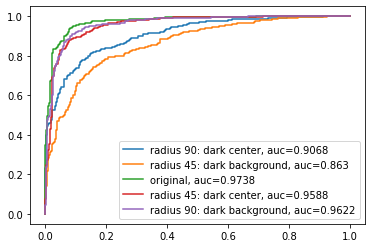

In [100]:
make_roc_plot("./outputs/probabilities/", 50, labels_skel, True)

In [102]:
labels_noskel = ['radius 45: dark background', 'radius 45: dark center', 'original', 'radius 90: dark background', 'radius 90: dark center']

['shadow_regions_dark_background_45_epoch50.csv', 'shadow_regions_dark_center_45_epoch50.csv', 'original_epoch50.csv', 'shadow_regions_dark_background_90_epoch50.csv', 'shadow_regions_dark_center_90_epoch50.csv']
radius 45: dark background
radius 45: dark center
original
radius 90: dark background
radius 90: dark center


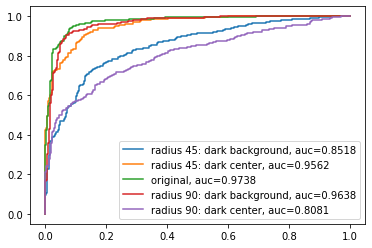

In [103]:
make_roc_plot("./outputs/probabilities/", 50, labels_noskel, False)

In [104]:
!ls

dataset  outputs


In [10]:
test_predictions

,img_loc,probability,race
0,dataset/test/black/101131.bmp,0.457056,0
1,dataset/test/black/101696.bmp,0.972327,0
2,dataset/test/black/101704.bmp,0.982587,0
3,dataset/test/black/101708.bmp,0.945986,0
4,dataset/test/black/101710.bmp,0.976698,0
...,...,...,...
905,dataset/test/white/99948.bmp,0.000573,1
906,dataset/test/white/99960.bmp,0.000091,1
907,dataset/test/white/99969.bmp,0.000517,1
908,dataset/test/white/99970.bmp,0.000056,1


In [15]:
roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])

0.9609432913269089

In [37]:
!pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [34]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(test_predictions['race'], 1 - test_predictions['probability'])
plt.show()

ModuleNotFoundError: No module named 'scikitplot'

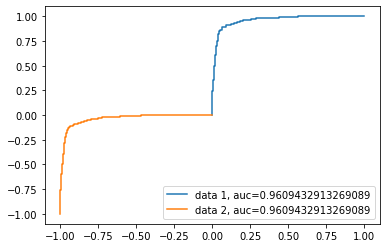

In [43]:
fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr-1,tpr-1,label="data 2, auc="+str(auc))

plt.legend(loc=4)
plt.show()

In [28]:
RocCurveDisplay.from_predictions(, )

AttributeError: type object 'RocCurveDisplay' has no attribute 'from_predictions'

In [24]:
black_test = test_predictions[test_predictions['race'] == 0]

In [26]:
len(black_test)

342

In [25]:
black_test[black_test['probability'] > 0.5]

,img_loc,probability,race
1,dataset/test/black/101696.bmp,0.972327,0
2,dataset/test/black/101704.bmp,0.982587,0
3,dataset/test/black/101708.bmp,0.945986,0
4,dataset/test/black/101710.bmp,0.976698,0
5,dataset/test/black/101711.bmp,0.995299,0
...,...,...,...
336,dataset/test/black/98322.bmp,0.927628,0
338,dataset/test/black/98336.bmp,0.995909,0
339,dataset/test/black/98339.bmp,0.574015,0
340,dataset/test/black/99051.bmp,0.979465,0


In [28]:
white_test = test_predictions[test_predictions['race'] == 1]

In [29]:
len(white_test)

568

In [31]:
white_test[white_test['probability'] < 0.5]

,img_loc,probability,race
342,dataset/test/white/100282.bmp,0.292915,1
344,dataset/test/white/100287.bmp,0.046928,1
345,dataset/test/white/100343.bmp,0.014933,1
346,dataset/test/white/100353.bmp,0.046055,1
347,dataset/test/white/100466.bmp,0.033951,1
...,...,...,...
905,dataset/test/white/99948.bmp,0.000573,1
906,dataset/test/white/99960.bmp,0.000091,1
907,dataset/test/white/99969.bmp,0.000517,1
908,dataset/test/white/99970.bmp,0.000056,1


In [27]:
# black acc

297/342

0.868421052631579

In [32]:
# white acc

523/568

0.920774647887324